Reference: https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [ ]:
# Load your CSV file using pandas
csv_file_path = '/content/sample_data/dataset_en.csv'
df = pd.read_csv(csv_file_path)

# Map string labels to numerical values
label_mapping = {"hate": 1, "nothate": 0}
df['label'] = df['label'].map(label_mapping)

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define a function to preprocess text data
def preprocess_text(text):
    # Add your text preprocessing steps here (e.g., tokenization, lowercase, etc.)
    # Convert text to lowercase
    return text

# Apply text preprocessing to your dataset
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# Create TensorFlow Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['text'], train_df['label']))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['text'], test_df['label']))

# Shuffle and batch the training dataset
batch_size = 32
train_dataset = train_dataset.shuffle(10000)
train_dataset = train_dataset.batch(batch_size)

# Batch the testing dataset
test_dataset = test_dataset.batch(batch_size)

In [ ]:
text, label = next(iter(train_dataset))
print('Text:\n', text.numpy()[0])
print('\nLabel: ', label.numpy()[0])

Text:
 b'The countries you called low IQ subhumans are less corrupt than India! If your country gets beaten by such so called genetically inferior people, What does that say about you?'

Label:  0


In [ ]:
# Using the TextVectorization layer to normalize, split, and map strings
# to integers.
encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(train_dataset.map(lambda text, _: text))

# Extracting the vocabulary from the TextVectorization layer.
vocabulary = np.array(encoder.get_vocabulary())

# Encoding a test example and decoding it back.
original_text = text.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  b'The countries you called low IQ subhumans are less corrupt than India! If your country gets beaten by such so called genetically inferior people, What does that say about you?'
encoded:  [   2  429   12  171  870 1011 3730    7  307 1204   88  674   41   66
   77  713 1979   75  105   21  171 3070  744   14   59  136   10   99
   45   12]
decoded:  the countries you called low iq subhumans are less corrupt than india if your country gets beaten by such so called genetically inferior people what does that say about you


In [ ]:
# Creating the model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Summary of the model
model.summary()

# Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [ ]:
# Training the model and validating it on test set
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
)

Epoch 1/50
1016/1016 [==============================] - 91s 72ms/step - loss: 0.5718 - accuracy: 0.6471 - val_loss: 0.5120 - val_accuracy: 0.6940
Epoch 2/50
1016/1016 [==============================] - 35s 34ms/step - loss: 0.4429 - accuracy: 0.7664 - val_loss: 0.4959 - val_accuracy: 0.7276
Epoch 3/50
1016/1016 [==============================] - 33s 32ms/step - loss: 0.3555 - accuracy: 0.8197 - val_loss: 0.5077 - val_accuracy: 0.7342
Epoch 4/50
1016/1016 [==============================] - 32s 32ms/step - loss: 0.2893 - accuracy: 0.8564 - val_loss: 0.5351 - val_accuracy: 0.7412
Epoch 5/50
1016/1016 [==============================] - 33s 32ms/step - loss: 0.2344 - accuracy: 0.8843 - val_loss: 0.7176 - val_accuracy: 0.7481
Epoch 6/50
1016/1016 [==============================] - 34s 33ms/step - loss: 0.1931 - accuracy: 0.9068 - val_loss: 0.7299 - val_accuracy: 0.7477
Epoch 7/50
1016/1016 [==============================] - 34s 34ms/step - loss: 0.1602 - accuracy: 0.9228 - val_loss: 0.8586 -

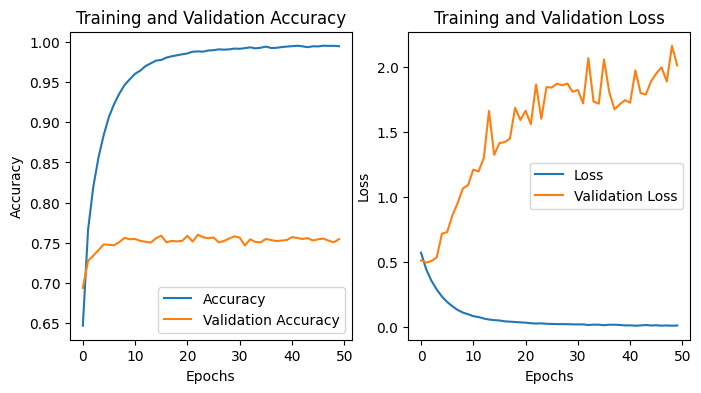

In [ ]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()


In [ ]:
# Making predictions
sample_text = (
	" helloooo"
)
predictions = model.predict(np.array([sample_text]))
print(*predictions[0])

# Print the label based on the prediction
if predictions[0] > 0:
	print('The review is positive')
else:
	print('The review is negative')


1/1 [==============================] - 0s 21ms/step
0.6731529
The review is positive


In [ ]:
export_dir = '/content/sample_data/saved_model'
tf.keras.models.save_model(model, export_dir)

In [ ]:
from google.colab import files
import shutil

shutil.make_archive("/content/sample_data/saved_model", "zip", "/content/sample_data/saved_model")
files.download("/content/sample_data/saved_model.zip")